In [1]:
%pip install qiskit==1.2.4
%pip install qiskit-aer==0.15.1
%pip install pylatexenc==2.10


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


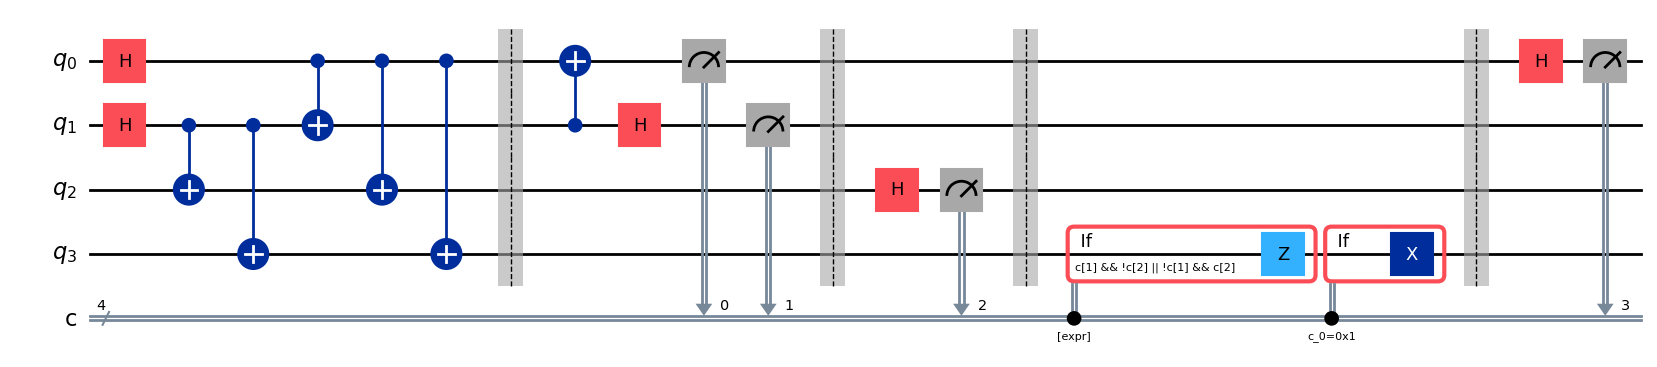

In [10]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_gate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit import transpile 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
from qiskit.circuit import ControlledGate
from qiskit.circuit.classical import expr
import math 
 
# The quantum secret sharing protocol from Lecture 12

# There are 4 qubits altogether; also 3 classical bits for the results of measurements
# during the protocol, and an extra classical bit for measurement and testing at the end.

qss = QuantumCircuit(4,4) 

# Qubit 0 is the one that Alice wants to share; put it into an interesting state

qss.h(0) 

# Construct a GHZ state on qubits 1, 2, 3

qss.h(1)
qss.cx(1,2) 
qss.cx(1,3) 

# Alice entangles qubit 0 with the GHZ state, by 3 cx operations.

qss.cx(0,1) 
qss.cx(0,2) 
qss.cx(0,3) 

qss.barrier() 

# Now Alice will transfer qubit 0 to Carol, requiring cooperation from Bob.

# Alice measures qubits 0 and 1 in the Bell basis. Be careful with this; it's in Lecture 11.

qss.cx(1,0) 
qss.h(1) 
qss.measure([0,1],[0,1]) 

qss.barrier() 

# Bob measures qubit 2 in the diagonal basis.

qss.h(2) 
qss.measure([2],[2]) 

qss.barrier() 

# We now assume that classical bits 0, 1, 2 have been sent to Carol.
# Carol applies operations to qubit 3, conditionally on bits 0, 1, 2.
# We can adapt this from the error correction step in the bit-flip code.

# If bits 1 and 2 are different, apply Z to qubit 3

with qss.if_test(expr.logic_or(expr.logic_and(qss.clbits[1],expr.logic_not(qss.clbits[2])), 
                               expr.logic_and(expr.logic_not(qss.clbits[1]),qss.clbits[2]))):
    qss.z(3)

# If bit 0 is 1, apply X to qubit 3

with qss.if_test((qss.clbits[0],1)): 
    qss.x(3) 

qss.barrier() 

# Measure qubit 3 in the diagonal basis. We are looking for a consistent 0.

qss.h(3) 
qss.measure([3],[3])

# Check the circuit

qss.draw("mpl")


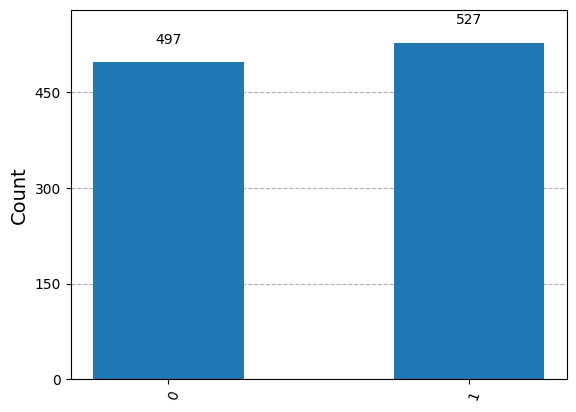

In [11]:
# Simulate and plot results

backend = GenericBackendV2(num_qubits=5, control_flow=True)
compiled = transpile(qss, backend)
job_sim = backend.run(compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(compiled)
# We only want to see the results for bit 3
mcounts = marginal_counts(counts,indices=[3]) 
plot_histogram(mcounts)